In [1]:
!pip install -q kaggle

In [2]:
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [3]:
!cp kaggle.json ~/.kaggle/

In [4]:
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download suneelreddy696699/images-for-sih

Dataset URL: https://www.kaggle.com/datasets/suneelreddy696699/images-for-sih
License(s): other
images-for-sih.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
!unzip images-for-sih.zip -d ./images-for-sih


Archive:  images-for-sih.zip
replace ./images-for-sih/Dataset/Noisy/noisy-image-1.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [7]:
#importing the necessary libraries
import torch
from torch import nn
import torchvision
from torchvision import transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from PIL import Image

print(torch.__version__)
print(torchvision.__version__)

2.5.1+cu121
0.20.1+cu121


In [8]:
#this is generated by the chatgpt that is used to add the shadows on the noisy images
import numpy as np
class AddBlackShadow:
    def __init__(self, shadow_factor_range=(0.1, 0.3), shadow_area=(0.5, 1.0)):
        """
        Args:
            shadow_factor_range: Tuple specifying the range of shadow intensity (0 = black, 1 = no change).
            shadow_area: Tuple specifying the proportion of the image to apply the shadow (e.g., 0.5 to 1.0).
        """
        self.shadow_factor_range = shadow_factor_range
        self.shadow_area = shadow_area

    def __call__(self, img):
        # Ensure input is a PIL image
        if not isinstance(img, Image.Image):
            raise TypeError(f"Expected input to be a PIL.Image, got {type(img)}")

        # Convert image to a NumPy array for pixel manipulation
        img_np = np.array(img)

        # Generate random shadow factor
        shadow_factor = random.uniform(*self.shadow_factor_range)

        # Generate random region for the shadow
        height, width, _ = img_np.shape
        shadow_height = int(height * random.uniform(*self.shadow_area))
        shadow_start = random.randint(0, height - shadow_height)


        img_np[shadow_start:shadow_start + shadow_height, :, :] = (
            img_np[shadow_start:shadow_start + shadow_height, :, :] * shadow_factor
        ).astype(np.uint8)

        return Image.fromarray(img_np)


In [9]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import random
import os

#taking the paths of the folders
noisy_folder = "/content/images-for-sih/Dataset/Noisy"
clean_folder = "/content/images-for-sih/Dataset/images"

#list of the file names that are in the noisy and the clean image folders
noisy_files = sorted(os.listdir(noisy_folder))
clean_files = sorted(os.listdir(clean_folder))

#creatimg the dataset
class ImagePairDataset(Dataset):
    def __init__(self, noisy_files, clean_files, noisy_folder, clean_folder, transform=None):
        self.noisy_files = noisy_files
        self.clean_files = clean_files
        self.noisy_folder = noisy_folder
        self.clean_folder = clean_folder
        self.transform = transform

    def __len__(self):
        return len(self.noisy_files)

    def __getitem__(self, idx):
        #loading the paths
        noisy_path = os.path.join(self.noisy_folder, self.noisy_files[idx])
        clean_path = os.path.join(self.clean_folder, self.clean_files[idx])

        noisy_image = Image.open(noisy_path).convert('RGB')
        clean_image = Image.open(clean_path).convert('RGB')

        #transformation and the noisy image
        if self.transform:
            noisy_image = self.transform(noisy_image)

        #clean images for mapping the noisy images without the augmentaion
        clean_image = transforms.ToTensor()(clean_image)

        return noisy_image, clean_image

#this is the transformation
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    AddBlackShadow(shadow_factor_range=(0.2, 0.6), shadow_area=(0.3, 0.7)),
    transforms.ToTensor()  # Convert to tensor
])

#dataset containing the mappings
dataset = ImagePairDataset(noisy_files, clean_files, noisy_folder, clean_folder, transform)



In [10]:
import random


In [23]:
image,label=dataset[0]

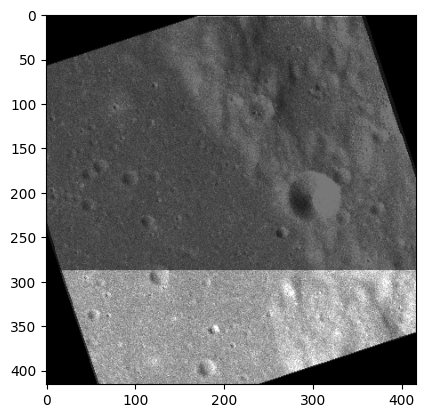

In [12]:
'''transposed_image = image.permute(1, 2, 0)
transposed_noisy=label.permute(1,2,0)
plt.imshow(transposed_image)
#plt.imshow(transposed_noisy)'''

In [13]:
type(dataset)

__main__.ImagePairDataset

In [14]:
len(dataset)

8741

In [15]:
from torch.utils.data import random_split

# Define split sizes
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

#splitting the dataset
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

#dataloader
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [16]:
test_loader.dataset

In [17]:
device="cuda" if torch.cuda.is_available() else "cpu"

In [18]:
device

'cuda'

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F

#Architecture
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()

        #encoder for downsampling
        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)

        # Bottleneck
        self.bottleneck = self.conv_block(512, 1024)

        #Decoder for upsamplingg
        self.upconv4 = self.upconv_block(1024, 512)
        self.upconv3 = self.upconv_block(512, 256)
        self.upconv2 = self.upconv_block(256, 128)
        self.upconv1 = self.upconv_block(128, 64)


        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channels),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

    def upconv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        #encoder
        enc1_out = self.enc1(x)
        enc2_out = self.enc2(enc1_out)
        enc3_out = self.enc3(enc2_out)
        enc4_out = self.enc4(enc3_out)


        bottleneck_out = self.bottleneck(enc4_out)

        #Decoder
        upconv4_out = self.upconv4(bottleneck_out)
        upconv3_out = self.upconv3(upconv4_out + enc4_out)
        upconv2_out = self.upconv2(upconv3_out + enc3_out)
        upconv1_out = self.upconv1(upconv2_out + enc2_out)

        # Final output layer
        output = self.final_conv(upconv1_out + enc1_out)

        return output





In [20]:
model_0 = UNet(in_channels=3, out_channels=1)  # Example: RGB input, binary segmentation output

In [24]:
image.shape

torch.Size([3, 416, 416])

In [26]:
image=image.unsqueeze(dim=1)

In [29]:
image.shape

torch.Size([3, 1, 416, 416])